In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# shap
import shap

# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# imblearn for SMOTE
from imblearn.over_sampling import SMOTE

import pymc as pm
import arviz as az

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [ ]:
plays_df = pd.read_csv('./data/plays.csv')
player_play_df = pd.read_csv('./data/player_play.csv')
games_df = pd.read_csv('./data/games.csv')

In [3]:
plays_df.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,...,yardsGained,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPointsAdded,isDropback,pff_runConceptPrimary,pff_runConceptSecondary,pff_runPassOption,pff_passCoverage,pff_manZone
0,2022102302,2655,(1:54) (Shotgun) J.Burrow pass short middle to...,3,1,10,CIN,ATL,CIN,21,...,9,0.004634,-0.004634,0.702717,True,NaN,NaN,0,Cover-3,Zone
1,2022091809,3698,(2:13) (Shotgun) J.Burrow pass short right to ...,4,1,10,CIN,DAL,CIN,8,...,4,0.002847,-0.002847,-0.240509,True,NaN,NaN,0,Quarters,Zone
2,2022103004,3146,(2:00) (Shotgun) D.Mills pass short right to D...,4,3,12,HOU,TEN,HOU,20,...,6,0.000205,-0.000205,-0.218480,True,NaN,NaN,0,Quarters,Zone
3,2022110610,348,(9:28) (Shotgun) P.Mahomes pass short left to ...,1,2,10,KC,TEN,TEN,23,...,4,-0.001308,0.001308,-0.427749,True,NaN,NaN,0,Quarters,Zone
4,2022102700,2799,(2:16) (Shotgun) L.Jackson up the middle to TB...,3,2,8,BAL,TB,TB,27,...,-1,0.027141,-0.027141,-0.638912,False,MAN,READ OPTION,0,Cover-1,Man


In [4]:
print(plays_df['playDescription'][0])

(1:54) (Shotgun) J.Burrow pass short middle to T.Boyd to CIN 30 for 9 yards (J.Hawkins).


In [5]:
player_play_df.head()

,gameId,playId,nflId,teamAbbr,hadRushAttempt,rushingYards,hadDropback,passingYards,sackYardsAsOffense,hadPassReception,...,wasRunningRoute,routeRan,blockedPlayerNFLId1,blockedPlayerNFLId2,blockedPlayerNFLId3,pressureAllowedAsBlocker,timeToPressureAllowedAsBlocker,pff_defensiveCoverageAssignment,pff_primaryDefensiveCoverageMatchupNflId,pff_secondaryDefensiveCoverageMatchupNflId
0,2022090800,56,35472,BUF,0,0,0,0,0,0,...,NaN,NaN,47917.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1,2022090800,56,42392,BUF,0,0,0,0,0,0,...,NaN,NaN,47917.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2,2022090800,56,42489,BUF,0,0,0,0,0,1,...,1.0,IN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022090800,56,44875,BUF,0,0,0,0,0,0,...,NaN,NaN,43335.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4,2022090800,56,44985,BUF,0,0,0,0,0,0,...,1.0,OUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
games_df.head()

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore
0,2022090800,2022,1,9/8/2022,20:20:00,LA,BUF,10,31
1,2022091100,2022,1,9/11/2022,13:00:00,ATL,NO,26,27
2,2022091101,2022,1,9/11/2022,13:00:00,CAR,CLE,24,26
3,2022091102,2022,1,9/11/2022,13:00:00,CHI,SF,19,10
4,2022091103,2022,1,9/11/2022,13:00:00,CIN,PIT,20,23


In [7]:
def merge_dataset(plays_df, games_df):
    """
    Combine 2 datasets into one based on the gameId column, and perform
    data cleaning and feature engineering.
    """
    df = plays_df.merge(games_df, on='gameId', how='left')
    
    df['is_pass'] = df['isDropback'].astype(int)
    df['is_home_team'] = df['possessionTeam'] == df['homeTeamAbbr']
    
    df['score_differential'] = np.where(
        df['is_home_team'],
        df['preSnapHomeScore'] - df['preSnapVisitorScore'],
        df['preSnapVisitorScore'] - df['preSnapHomeScore']
    )
    
    print(f"Data set length: {len(df)}")
    print(df.info())
    
    return df

In [8]:
df = merge_dataset(plays_df, games_df)

Data set length: 16124
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16124 entries, 0 to 16123
Data columns (total 61 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   gameId                            16124 non-null  int64  
 1   playId                            16124 non-null  int64  
 2   playDescription                   16124 non-null  object 
 3   quarter                           16124 non-null  int64  
 4   down                              16124 non-null  int64  
 5   yardsToGo                         16124 non-null  int64  
 6   possessionTeam                    16124 non-null  object 
 7   defensiveTeam                     16124 non-null  object 
 8   yardlineSide                      15900 non-null  object 
 9   yardlineNumber                    16124 non-null  int64  
 10  gameClock                         16124 non-null  object 
 11  preSnapHomeScore                  16124 non-

In [9]:
print("\nRun/Pass Distribution:")
print(df['is_pass'].value_counts(normalize=True))


Run/Pass Distribution:
is_pass
1    0.60382
0    0.39618
Name: proportion, dtype: float64


In [10]:
def create_situational_features(df):
    """
    Create situational features related to down, distance, field position and time
    """
    # Create a copy to avoid modifying original
    feature_df = df.copy()
    
    # One-hot encode down
    feature_df = pd.get_dummies(feature_df, columns=['down'], prefix='down')
    
    # Distance situations
    feature_df['distance_short'] = feature_df['yardsToGo'] <= 3
    feature_df['distance_long'] = feature_df['yardsToGo'] >= 7
    feature_df['is_third_and_long'] = (feature_df['down_3'] == 1) & feature_df['distance_long']
    
    # Normalize yard line (0 = own goal line, 100 = opponent goal line)
    feature_df['yards_to_goal'] = 100 - feature_df['absoluteYardlineNumber']
    feature_df['in_redzone'] = feature_df['yards_to_goal'] <= 20
    feature_df['backed_up'] = feature_df['absoluteYardlineNumber'] <= 10
    
    # Convert game clock to seconds remaining in quarter
    feature_df['game_clock_seconds'] = feature_df['gameClock'].apply(
        lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1])
    )
    
    # End of half situations (last 2 minutes)
    feature_df['end_of_half'] = (feature_df['quarter'].isin([2, 4])) & \
                               (feature_df['game_clock_seconds'] <= 120)
    
    # === Score Situation Features ===
    feature_df['score_differential_bucket'] = pd.cut(
        feature_df['score_differential'],
        bins=[-100, -17, -9, -3, 3, 9, 17, 100],
        labels=['big_deficit', 'medium_deficit', 'small_deficit', 
                'close', 'small_lead', 'medium_lead', 'big_lead']
    )
    
    feature_df['time_remaining_half'] = feature_df.apply(lambda x: 
        1800 if x['quarter'] <= 2 else 3600 - x['game_clock_seconds'], axis=1)
    
    # Win probability features
    feature_df['win_prob_differential'] = feature_df['preSnapHomeTeamWinProbability'] - feature_df['preSnapVisitorTeamWinProbability']
    
    
    return feature_df

In [11]:
# Apply the features
df_with_features = create_situational_features(df)

# Let's examine our new features
print("New features created:")
new_features = [col for col in df_with_features.columns if col not in df.columns]
print("\n".join(new_features))

New features created:
down_1
down_2
down_3
down_4
distance_short
distance_long
is_third_and_long
yards_to_goal
in_redzone
backed_up
game_clock_seconds
end_of_half
score_differential_bucket
time_remaining_half
win_prob_differential


In [12]:
# Quick validation
print("\nFeature Statistics:")
for feature in new_features:
    if df_with_features[feature].dtype in ['int64', 'float64']:
        print(f"\n{feature}:")
        print(df_with_features[feature].describe())


Feature Statistics:

yards_to_goal:
count    16124.000000
mean        39.586517
std         24.326003
min         -9.000000
25%         19.000000
50%         39.000000
75%         60.000000
max         89.000000
Name: yards_to_goal, dtype: float64

game_clock_seconds:
count    16124.000000
mean       430.040995
std        271.988113
min          1.000000
25%        181.000000
50%        420.000000
75%        667.000000
max        900.000000
Name: game_clock_seconds, dtype: float64

time_remaining_half:
count    16124.000000
mean      2490.580191
std        709.386211
min       1800.000000
25%       1800.000000
50%       2700.000000
75%       3185.000000
max       3599.000000
Name: time_remaining_half, dtype: float64

win_prob_differential:
count    16124.000000
mean         0.104015
std          0.581206
min         -0.997901
25%         -0.350775
50%          0.157844
75%          0.583201
max          0.998393
Name: win_prob_differential, dtype: float64


In [13]:
# Check relationship with target
print("\nPass Play Percentage by Situation:")
situations = [
    ('is_third_and_long', 'Third and Long'),
    ('in_redzone', 'Red Zone'),
    ('end_of_half', 'End of Half'),
]

for col, label in situations:
    pass_pct = df_with_features[df_with_features[col]][['is_pass']].mean()
    print(f"\n{label}: {pass_pct['is_pass']:.3f}")


Pass Play Percentage by Situation:

Third and Long: 0.920

Red Zone: 0.595

End of Half: 0.709


In [14]:
# Validation checks
print("Null values:", df_with_features[new_features].isnull().sum().sum())

Null values: 0


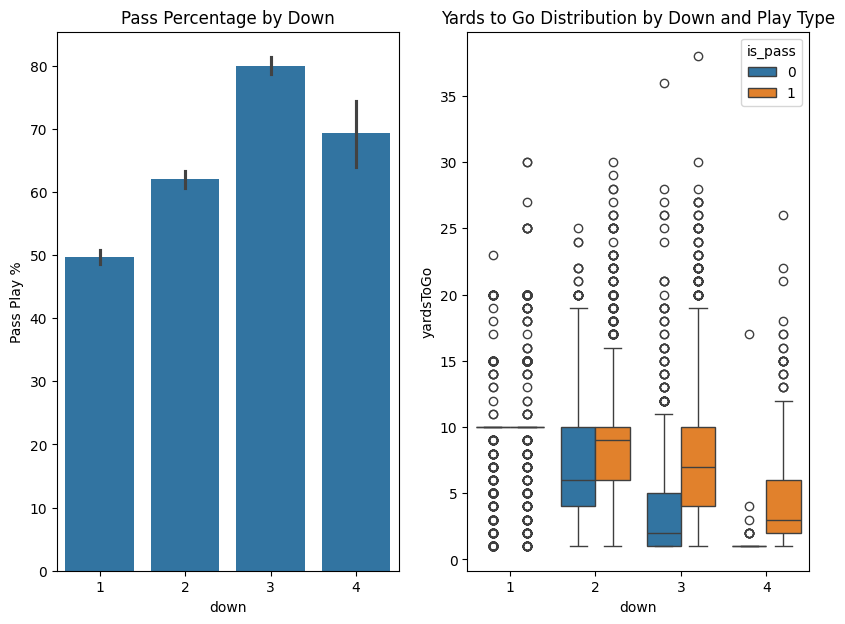

In [15]:
plt.figure(figsize=(15, 7))
plt.subplot(131)
sns.barplot(data=df, x='down', y='is_pass', 
            errorbar=('ci', 95), estimator=lambda x: sum(x)/len(x)*100)
plt.title('Pass Percentage by Down')
plt.ylabel('Pass Play %')

plt.subplot(132)
sns.boxplot(data=df, x='down', y='yardsToGo', hue='is_pass')
plt.title('Yards to Go Distribution by Down and Play Type')

plt.show()

In [16]:
print("Available columns:")
print(df_with_features.columns.tolist())

Available columns:
['gameId', 'playId', 'playDescription', 'quarter', 'yardsToGo', 'possessionTeam', 'defensiveTeam', 'yardlineSide', 'yardlineNumber', 'gameClock', 'preSnapHomeScore', 'preSnapVisitorScore', 'playNullifiedByPenalty', 'absoluteYardlineNumber', 'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability', 'expectedPoints', 'offenseFormation', 'receiverAlignment', 'playClockAtSnap', 'passResult', 'passLength', 'targetX', 'targetY', 'playAction', 'dropbackType', 'dropbackDistance', 'passLocationType', 'timeToThrow', 'timeInTackleBox', 'timeToSack', 'passTippedAtLine', 'unblockedPressure', 'qbSpike', 'qbKneel', 'qbSneak', 'rushLocationType', 'penaltyYards', 'prePenaltyYardsGained', 'yardsGained', 'homeTeamWinProbabilityAdded', 'visitorTeamWinProbilityAdded', 'expectedPointsAdded', 'isDropback', 'pff_runConceptPrimary', 'pff_runConceptSecondary', 'pff_runPassOption', 'pff_passCoverage', 'pff_manZone', 'season', 'week', 'gameDate', 'gameTimeEastern', 'homeTeamAbbr', 'v

In [17]:
def create_formation_features(df):
    """
    Create features based on offensive formation and receiver alignment
    """
    feature_df = df.copy()
    feature_df['offenseFormation'] = feature_df['offenseFormation'].fillna('UNKNOWN')
    
    # One-hot encode base formation
    feature_df = pd.get_dummies(feature_df, columns=['offenseFormation'], prefix='formation')
    
    # Clean and process receiver alignment
    feature_df['receiverAlignment'] = feature_df['receiverAlignment'].fillna('0x0')
    
    # Extract receiver alignment (3x2 is 3 left 2 right)
    alignment_split = feature_df['receiverAlignment'].str.extract(r'(\d)x(\d)')
    feature_df['receivers_left'] = pd.to_numeric(alignment_split[0], errors='coerce').fillna(0)
    feature_df['receivers_right'] = pd.to_numeric(alignment_split[1], errors='coerce').fillna(0)
    
    # Total receivers wide
    feature_df['total_receivers_wide'] = feature_df['receivers_left'] + feature_df['receivers_right']
    
    # Balanced/Unbalanced formation
    feature_df['is_balanced'] = feature_df['receivers_left'] == feature_df['receivers_right']
    
    # Empty backfield (5 or more receivers wide, then backfield is empty)
    feature_df['is_empty'] = feature_df['total_receivers_wide'] >= 5
    
    # Play action indicator
    feature_df['has_playaction'] = feature_df['playAction'].fillna(False)
    
    # Shotgun vs Under Center (from playDescription)
    feature_df['is_shotgun'] = feature_df['playDescription'].str.contains('Shotgun', case=False, na=False)
    
    # Heavy personnel (based on receiver count)
    feature_df['is_heavy_formation'] = feature_df['total_receivers_wide'] <= 2
    feature_df['is_light_formation'] = feature_df['total_receivers_wide'] >= 4
    
    # Trips indicator (3 receivers to one side)
    feature_df['has_trips'] = (feature_df['receivers_left'] == 3) | (feature_df['receivers_right'] == 3)
    
    return feature_df

In [18]:
# Apply the formation features
df_with_formations = create_formation_features(df_with_features)

# Display new features
print("New formation features created:")
formation_features = [col for col in df_with_formations.columns if col not in df_with_features.columns]
print("\n".join(formation_features))

New formation features created:
formation_EMPTY
formation_I_FORM
formation_JUMBO
formation_PISTOL
formation_SHOTGUN
formation_SINGLEBACK
formation_UNKNOWN
formation_WILDCAT
receivers_left
receivers_right
total_receivers_wide
is_balanced
is_empty
has_playaction
is_shotgun
is_heavy_formation
is_light_formation
has_trips


In [19]:
# Basic analysis
print("\nFormation Distribution:")
for col in formation_features:
    if df_with_formations[col].dtype in ['int64', 'float64', 'bool']:
        pass_rate = df_with_formations[df_with_formations[col] == 1]['is_pass'].mean()
        count = df_with_formations[col].sum()
        print(f"\n{col}:")
        print(f"Count: {count}")
        print(f"Pass rate: {pass_rate:.3f}")


Formation Distribution:

formation_EMPTY:
Count: 1342
Pass rate: 0.965

formation_I_FORM:
Count: 1035
Pass rate: 0.289

formation_JUMBO:
Count: 125
Pass rate: 0.168

formation_PISTOL:
Count: 641
Pass rate: 0.353

formation_SHOTGUN:
Count: 8791
Pass rate: 0.745

formation_SINGLEBACK:
Count: 3915
Pass rate: 0.334

formation_UNKNOWN:
Count: 188
Pass rate: 0.122

formation_WILDCAT:
Count: 87
Pass rate: 0.149

receivers_left:
Count: 39250
Pass rate: 0.250

receivers_right:
Count: 23592
Pass rate: 0.565

total_receivers_wide:
Count: 62842
Pass rate: 0.125

is_balanced:
Count: 6832
Pass rate: 0.582

is_empty:
Count: 1363
Pass rate: 0.954

has_playaction:
Count: 2745
Pass rate: 0.899

is_shotgun:
Count: 10839
Pass rate: 0.746

is_heavy_formation:
Count: 401
Pass rate: 0.182

is_light_formation:
Count: 13890
Pass rate: 0.650

has_trips:
Count: 7286
Pass rate: 0.686


In [20]:
# Validation checks
print("Null values:",df_with_formations[formation_features].isnull().sum().sum())

Null values: 0


In [21]:
import numpy as np

def create_historical_tendencies(df):
    """
    Create basic historical tendency features using only prior information
    """
    feature_df = df.copy()
    feature_df = feature_df.sort_values(['gameId', 'playId'])
    
    # Overall team pass tendency (last 20 plays)
    feature_df['team_pass_tendency'] = feature_df.groupby('possessionTeam')['is_pass'].transform(
        lambda x: x.rolling(window=20, min_periods=1).mean().shift(1).fillna(x.mean())
    )
    # Last 3 plays
    feature_df['recent_tendency'] = feature_df.groupby('possessionTeam')['is_pass'].transform(
        lambda x: x.rolling(window=3, min_periods=1).mean().shift(1).fillna(x.mean())
    )
    # Team tendency
    feature_df['team_overall_pass_tendency'] = feature_df.groupby('possessionTeam')['is_pass'].transform('mean')
    # Situational tendencies
    feature_df['down_distance_pass_tendency'] = feature_df.groupby(['down_1', 'down_2', 'down_3', 'down_4', 'distance_short', 'distance_long'])['is_pass'].transform('mean')
    
    return feature_df

In [22]:
# Apply historical tendency features
df_with_tendencies = create_historical_tendencies(df_with_formations)

In [23]:
tendency_features = ['team_pass_tendency', 'recent_tendency']

# Basic statistics
print("\nFeature Statistics:")
print(df_with_tendencies[tendency_features].describe())

# Example for one team
sample_team = df_with_tendencies['possessionTeam'].iloc[0]
print(f"\nExample for team {sample_team}:")
team_sample = df_with_tendencies[df_with_tendencies['possessionTeam'] == sample_team].head(10)
print(team_sample[['is_pass', 'team_pass_tendency', 'recent_tendency']])

# Check correlation with actual play calls
print("\nCorrelations with is_pass:")
correlations = df_with_tendencies[tendency_features].corrwith(df_with_tendencies['is_pass'])
print(correlations.sort_values(ascending=False))


Feature Statistics:
       team_pass_tendency  recent_tendency
count        16124.000000     16124.000000
mean             0.604611         0.604271
std              0.154372         0.296009
min              0.000000         0.000000
25%              0.500000         0.333333
50%              0.600000         0.666667
75%              0.700000         0.666667
max              1.000000         1.000000

Example for team BUF:
       is_pass  team_pass_tendency  recent_tendency
13368        1            0.673774         0.673774
2660         1            1.000000         1.000000
7042         0            1.000000         1.000000
2909         1            0.666667         0.666667
10143        1            0.750000         0.666667
5958         0            0.800000         0.666667
16048        1            0.666667         0.666667
13120        1            0.714286         0.666667
7941         0            0.750000         0.666667
4015         1            0.666667         0.6666

In [24]:
print(df_with_tendencies.columns.tolist())

['gameId', 'playId', 'playDescription', 'quarter', 'yardsToGo', 'possessionTeam', 'defensiveTeam', 'yardlineSide', 'yardlineNumber', 'gameClock', 'preSnapHomeScore', 'preSnapVisitorScore', 'playNullifiedByPenalty', 'absoluteYardlineNumber', 'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability', 'expectedPoints', 'receiverAlignment', 'playClockAtSnap', 'passResult', 'passLength', 'targetX', 'targetY', 'playAction', 'dropbackType', 'dropbackDistance', 'passLocationType', 'timeToThrow', 'timeInTackleBox', 'timeToSack', 'passTippedAtLine', 'unblockedPressure', 'qbSpike', 'qbKneel', 'qbSneak', 'rushLocationType', 'penaltyYards', 'prePenaltyYardsGained', 'yardsGained', 'homeTeamWinProbabilityAdded', 'visitorTeamWinProbilityAdded', 'expectedPointsAdded', 'isDropback', 'pff_runConceptPrimary', 'pff_runConceptSecondary', 'pff_runPassOption', 'pff_passCoverage', 'pff_manZone', 'season', 'week', 'gameDate', 'gameTimeEastern', 'homeTeamAbbr', 'visitorTeamAbbr', 'homeFinalScore', 'vis

In [25]:
def prepare_final_features(df):
    """
    Combine all relevant features into final modeling dataset
    Keep only the most important predictive features
    """
    features_df = df.copy()
     
    # features
    basic_features = [
        'gameId', 'playId',
        'down_1', 'down_2', 'down_3', 'down_4',
        'yardsToGo',
        'yards_to_goal',
        'yardlineNumber',
        'absoluteYardlineNumber',
        'score_differential',
        'quarter',
        'game_clock_seconds',
        'team_pass_tendency',
        'recent_tendency',
        'team_overall_pass_tendency',
        'down_distance_pass_tendency',
        'distance_short',
        'distance_long',
        'is_third_and_long',
        'in_redzone',
        'backed_up',
        'end_of_half',
        'score_differential',
        'time_remaining_half',
        'win_prob_differential',
    ]
    
    # final feature set
    X = features_df[basic_features + formation_features]
    y = features_df['is_pass']
    
    # check feature set
    print("Final feature set:")
    print(X.columns.tolist())
    print("\nFeature set shape:", X.shape)
    print("\nClass distribution:")
    print(y.value_counts(normalize=True))
    
    return X, y, features_df[basic_features + formation_features]

In [26]:
# Create final feature set
X, y, train_df = prepare_final_features(df_with_tendencies)

Final feature set:
['gameId', 'playId', 'down_1', 'down_2', 'down_3', 'down_4', 'yardsToGo', 'yards_to_goal', 'yardlineNumber', 'absoluteYardlineNumber', 'score_differential', 'quarter', 'game_clock_seconds', 'team_pass_tendency', 'recent_tendency', 'team_overall_pass_tendency', 'down_distance_pass_tendency', 'distance_short', 'distance_long', 'is_third_and_long', 'in_redzone', 'backed_up', 'end_of_half', 'score_differential', 'time_remaining_half', 'win_prob_differential', 'formation_EMPTY', 'formation_I_FORM', 'formation_JUMBO', 'formation_PISTOL', 'formation_SHOTGUN', 'formation_SINGLEBACK', 'formation_UNKNOWN', 'formation_WILDCAT', 'receivers_left', 'receivers_right', 'total_receivers_wide', 'is_balanced', 'is_empty', 'has_playaction', 'is_shotgun', 'is_heavy_formation', 'is_light_formation', 'has_trips']

Feature set shape: (16124, 44)

Class distribution:
is_pass
1    0.60382
0    0.39618
Name: proportion, dtype: float64


# python script 

Combine all tracking_week_*.csv files into one dataframe. Keep only the BEFORE_SNAP frames. Keep only the last 10 frames before the snap. Calculate the number of players with significant movement (speed > 0.62) for each play. Add this as a feature to the plays dataframe.

```python
import pandas as pd
import glob
# Keep track of our target plays
valid_plays = plays_df[['gameId', 'playId']].copy()
all_motion = []

for file in sorted(glob.glob('tracking_week_*.csv')):
    df = pd.read_csv(file)
    df = df[df['frameType'] == 'BEFORE_SNAP']
    
    # Get last 10 frames before snap for each play
    df = df.groupby(['gameId', 'playId']).tail(10)
    
    motion_features = df.groupby(['gameId', 'playId']).agg({
        's': lambda x: (x > 0.62).sum(),  # Count frames with significant movement
        'x': lambda x: x.max() - x.min(),  # Total lateral movement
    }).reset_index()
    
    all_motion.append(motion_features)
    print(f"Processed {file}: {len(motion_features)} plays") ```

In [27]:
# get combined tracking weeks csv
motion_features = pd.read_csv('./motion_features.csv') 
valid_plays = plays_df[['gameId', 'playId']].copy()
all_motion = []

# Create more granular motion features
motion_features['motion_frames'] = motion_features['s']  # Raw count of motion frames
motion_features['total_movement'] = motion_features['x']  # Raw movement distance

# Create numerical motion levels (0-3)
motion_features['motion_level'] = pd.cut(motion_features['s'],
                                       bins=[-float('inf'), 0, 3, 6, float('inf')],
                                       labels=[0, 1, 2, 3]).astype(float)

# Calculate motion intensity (movement per frame with motion)
motion_features['motion_intensity'] = motion_features['x'] / motion_features['s'].clip(lower=1)

# Create binary flags with adjusted thresholds
motion_features['has_motion'] = (motion_features['s'] >= 2).astype(float)
motion_features['significant_movement'] = (motion_features['x'] > 1.5).astype(float)
motion_features['high_intensity'] = (motion_features['motion_intensity'] > 0.3).astype(float)

# Merge with valid plays
final_motion = motion_features.merge(valid_plays, on=['gameId', 'playId'], how='right')

print(f"Total plays processed: {len(final_motion)}")
print(f"Plays with motion: {final_motion['has_motion'].sum()}")
print(f"Plays with significant movement: {final_motion['significant_movement'].sum()}")
print(f"Plays with high intensity motion: {final_motion['high_intensity'].sum()}")
print(final_motion['motion_level'].value_counts(normalize=True))

Total plays processed: 16124
Plays with motion: 1663.0
Plays with significant movement: 248.0
Plays with high intensity motion: 1806.0
motion_level
0.0    0.749922
1.0    0.230163
2.0    0.014083
3.0    0.005832
Name: proportion, dtype: float64


In [28]:
# merge with original features
final_motion = final_motion.fillna(0)
X= X.merge(final_motion[['gameId', 'playId', 'has_motion', 'significant_movement']], 
                                    on=['gameId', 'playId'])
print(f"\nFinal feature set shape: {train_df.shape}")


Final feature set shape: (16124, 44)


In [29]:
print(len(train_df.dtypes == 'object'))

44


c:\Users\909ca\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\909ca\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


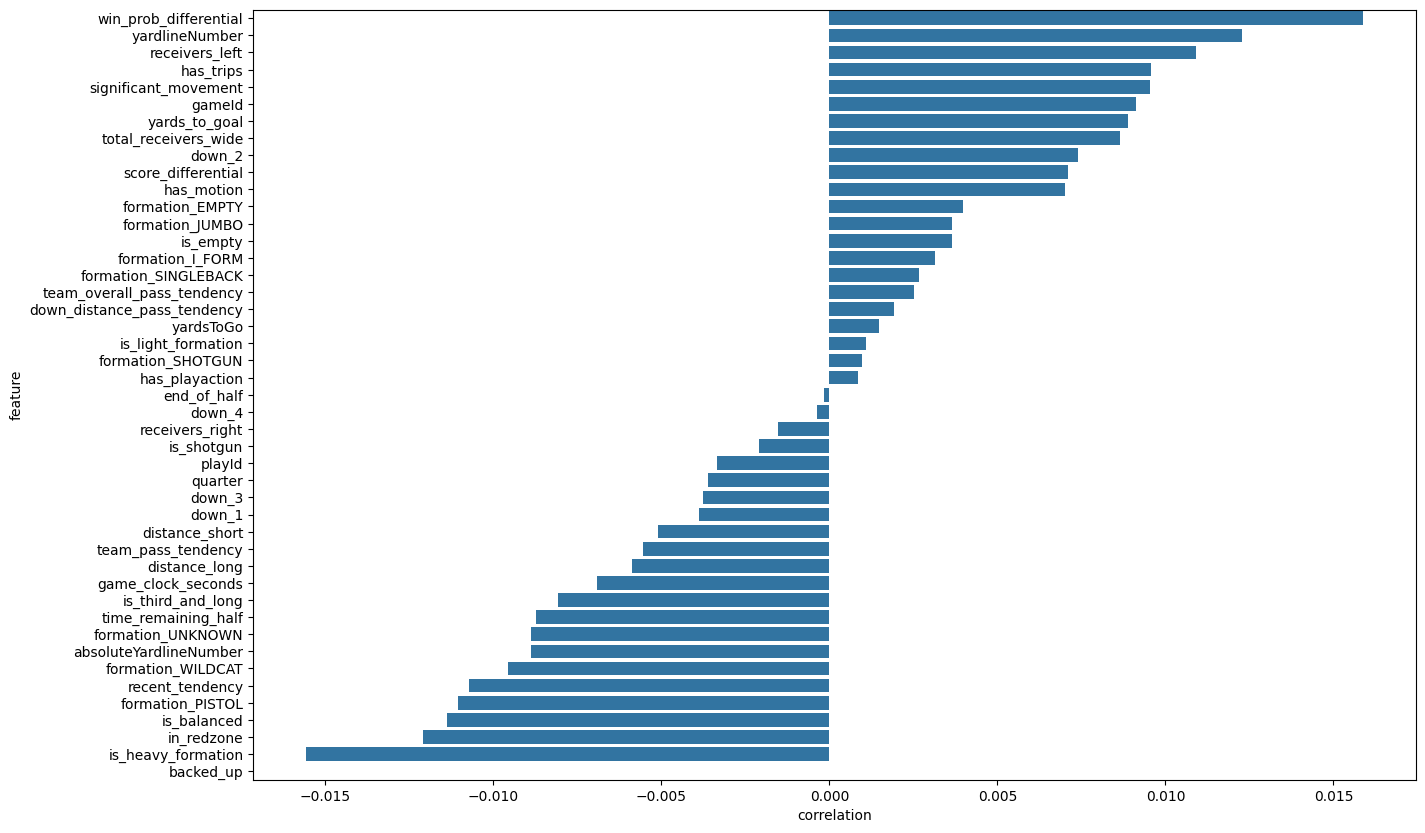

In [30]:
# Quick look at feature correlations with target
correlations = pd.DataFrame({
    'feature': X.columns,
    'correlation': X.corrwith(y)
}).sort_values('correlation', ascending=False)

# Remove any duplicate feature names that could cause reindexing issues
correlations = correlations[~correlations['feature'].duplicated()]
plt.figure(figsize=(15, 10))
sns.barplot(x='correlation', y='feature', data=correlations, orient='h')
plt.show()

In [31]:
print(len(X.columns.tolist()))

46


In [32]:
# Helper Dataset class
class PlayPredictionDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        if hasattr(targets, 'values'):
            targets = targets.values
        self.targets = torch.FloatTensor(targets)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

In [33]:
# First split the data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_val_scaled = scaler.transform(X_val)

# Create datasets
train_dataset = PlayPredictionDataset(X_train_scaled, y_train_balanced)
val_dataset = PlayPredictionDataset(X_val_scaled, y_val)

In [34]:
import torch
import torch.nn as nn

class PlayCNN(nn.Module):
    def __init__(self, input_features=46):
        super(PlayCNN, self).__init__()
        
        # Reduced initial dense layer (4096 -> 2048)
        self.dense1 = nn.Linear(input_features, 4096)
        
        # Reduced number of filters (512 -> 256)
        # kernel size (16 x 1)
        self.conv_block1 = nn.Sequential(
            nn.Conv1d(256, 512, kernel_size=16, padding=7),
            nn.AvgPool1d(kernel_size=2, stride=2)
        )
        
        # 2 sequential Conv 512 * 512 layers. (8 x 1) kernel
        self.conv_block2 = nn.Sequential(
            nn.Conv1d(512, 512, kernel_size=8, padding=3),
            nn.Conv1d(512, 512, kernel_size=8, padding=3)
        )
        
        self.max_pool = nn.MaxPool1d(kernel_size=4)
        
        self._to_linear = None
        self._get_conv_output_size(torch.randn(1, input_features))
        
        self.dense2 = nn.Linear(self._to_linear, 1)
        
    def _get_conv_output_size(self, x):
        x = self.dense1(x)
        x = x.view(-1, 128, 16)
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.max_pool(x)
        if self._to_linear is None:
            self._to_linear = x.flatten(1).shape[1]
    
    def forward(self, x):
        x = self.dense1(x)
        x = x.view(-1, 128, 16)
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.max_pool(x)
        x = x.flatten(1)
        x = self.dense2(x)
        return torch.sigmoid(x)

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2048, shuffle=False)

# Initialize model with adjusted parameters
model = PlayCNN().to(device) 

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.5,
    patience=5,
    min_lr=1e-4,
    verbose=True
)    

Using device: cuda


c:\Users\909ca\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [36]:
model

PlayCNN(
  (dense1): Linear(in_features=46, out_features=2048, bias=True)
  (conv_block1): Sequential(
    (0): Conv1d(128, 256, kernel_size=(16,), stride=(1,), padding=(7,))
    (1): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  )
  (conv_block2): Sequential(
    (0): Conv1d(256, 256, kernel_size=(8,), stride=(1,), padding=(3,))
    (1): Conv1d(256, 256, kernel_size=(8,), stride=(1,), padding=(3,))
  )
  (max_pool): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (dense2): Linear(in_features=256, out_features=1, bias=True)
)

In [37]:
best_val_auc = 0
patience = 7
patience_counter = 0
epochs = 100

# Training history
train_losses = []
val_losses = []
val_aucs = []
for epoch in range(epochs):
    # Training
    model.train()
    total_loss = 0
    for features, targets in train_loader:
        features, targets = features.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        # Gradient clipping to prevent exploding gradients
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    val_loss = 0
    predictions = []
    true_values = []
    
    with torch.no_grad():
        for features, targets in val_loader:
            features, targets = features.to(device), targets.to(device)
            outputs = model(features)
            val_loss += criterion(outputs, targets.unsqueeze(1)).item()
                
            predictions.extend(outputs.cpu().numpy())
            true_values.extend(targets.cpu().numpy())
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_auc = roc_auc_score(true_values, predictions)
    val_aucs.append(val_auc)
    
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f'Epoch {epoch+1}/{epochs}:')
    print(f'Training Loss: {avg_train_loss:.4f}')
    print(f'Validation Loss: {avg_val_loss:.4f}')
    print(f'Validation AUC: {val_auc:.4f}')
    print(f'Learning Rate: {current_lr:.6f}')
    print('------------------------')
    

Epoch 1/100:
Training Loss: 0.6899
Validation Loss: 0.6938
Validation AUC: 0.6665
Learning Rate: 0.001000
------------------------
Epoch 2/100:
Training Loss: 0.6880
Validation Loss: 0.6912
Validation AUC: 0.7291
Learning Rate: 0.001000
------------------------
Epoch 3/100:
Training Loss: 0.6851
Validation Loss: 0.6880
Validation AUC: 0.7691
Learning Rate: 0.001000
------------------------
Epoch 4/100:
Training Loss: 0.6820
Validation Loss: 0.6845
Validation AUC: 0.7915
Learning Rate: 0.001000
------------------------
Epoch 5/100:
Training Loss: 0.6787
Validation Loss: 0.6810
Validation AUC: 0.8047
Learning Rate: 0.001000
------------------------
Epoch 6/100:
Training Loss: 0.6752
Validation Loss: 0.6774
Validation AUC: 0.8128
Learning Rate: 0.001000
------------------------
Epoch 7/100:
Training Loss: 0.6717
Validation Loss: 0.6737
Validation AUC: 0.8180
Learning Rate: 0.001000
------------------------
Epoch 8/100:
Training Loss: 0.6681
Validation Loss: 0.6699
Validation AUC: 0.8217
L

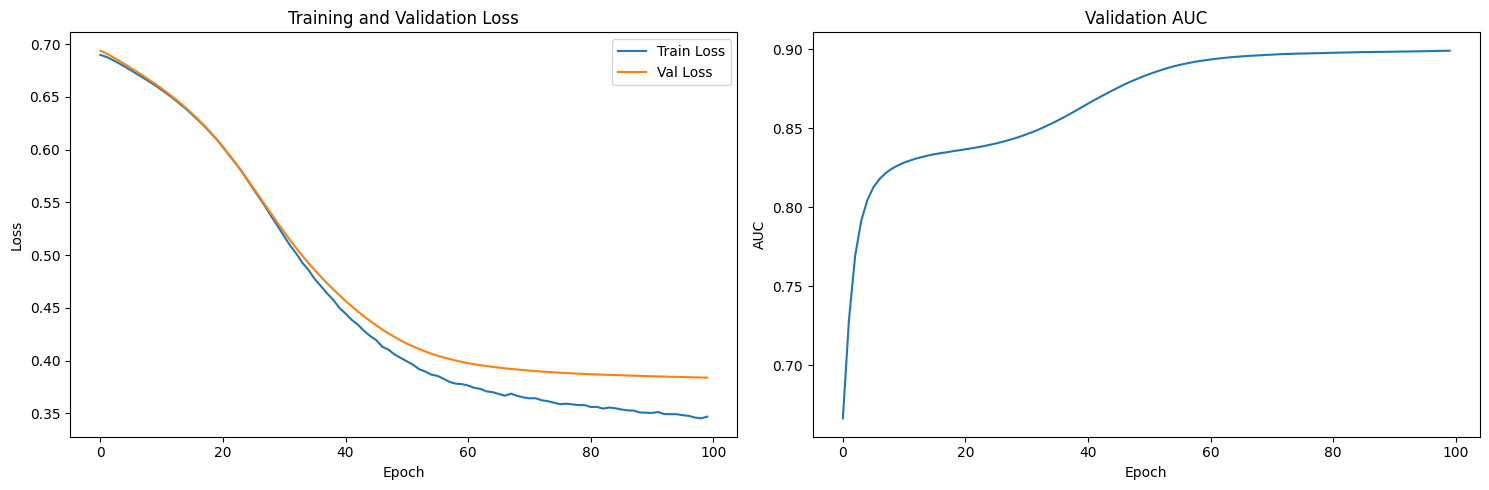

In [48]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_aucs)
plt.title('Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.tight_layout()
plt.show()

# Keep Track of evaluation metrics

Save eval metrics to a csv.

In [49]:
eval_metrics = {
    'Best Validation AUC': max(val_aucs),
    'Final Validation AUC': val_aucs[-1],
    'Best Training Loss': min(train_losses),
    'Final Training Loss': train_losses[-1],
    'Best Validation Loss': min(val_losses),
    'Final Validation Loss': val_losses[-1]
}
eval_df = pd.DataFrame(data=eval_metrics, index=[0]).describe()

eval_df.to_csv('eval_metrics.csv', index=False)

In [50]:
def predict(model, scaler, features, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    features_scaled = scaler.transform(features)
    features_tensor = torch.FloatTensor(features_scaled).to(device)
    # Get prediction
    model.eval()
    with torch.no_grad():
        prediction = model(features_tensor)
    
    return prediction.cpu().numpy()

In [51]:
# Example prediction
sample_play = X.iloc[[10]]
pred = predict(model, scaler, sample_play)
print(f"play: {sample_play}")
print(f"Probability of pass: {pred[0][0]:.3f}")

play:         gameId  playId  down_1  down_2  down_3  down_4  yardsToGo  \
10  2022090800     364   False   False    True   False          8   

    yards_to_goal  yardlineNumber  absoluteYardlineNumber  ...  \
10             71              19                      29  ...   

    total_receivers_wide  is_balanced  is_empty  has_playaction  is_shotgun  \
10                     4        False     False           False        True   

    is_heavy_formation  is_light_formation  has_trips  has_motion  \
10               False                True       True         0.0   

    significant_movement  
10                   0.0  

[1 rows x 46 columns]
Probability of pass: 0.875


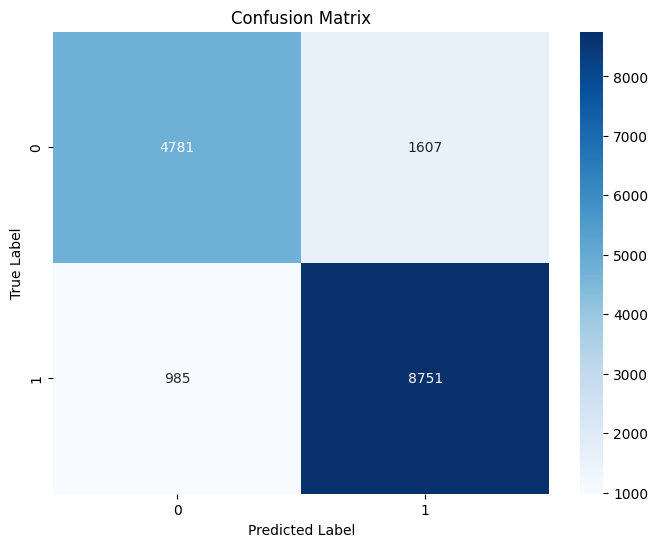

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_proba = predict(model, scaler, X)[:, 0]
y_true = y.values 

y_pred = (y_pred_proba > 0.5).astype(int)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [53]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.75      0.79      6388
           1       0.84      0.90      0.87      9736

    accuracy                           0.84     16124
   macro avg       0.84      0.82      0.83     16124
weighted avg       0.84      0.84      0.84     16124



In [54]:
import shap
model.eval()

# Create background dataset from training data
background = torch.FloatTensor(scaler.transform(X[:1000])).to(device)
test_targets = torch.FloatTensor(scaler.transform(X[:1000])).to(device)

# Create explainer using background data
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_targets, check_additivity=False)

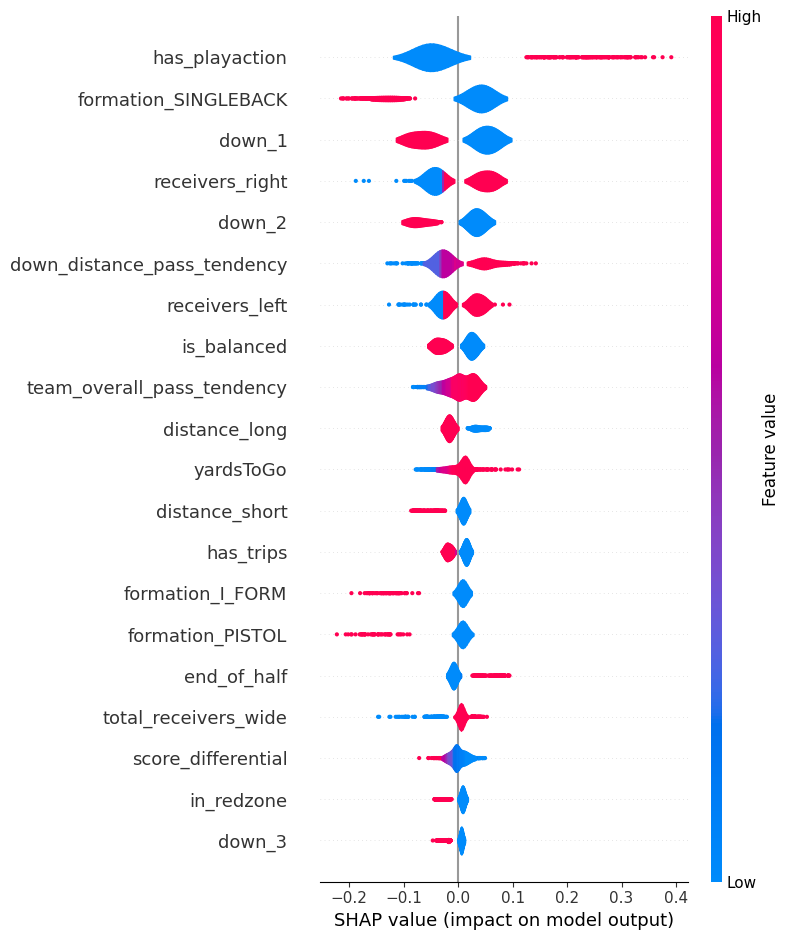

In [45]:
# Create plots
plt.figure(figsize=(15, 10))
shap.summary_plot(shap_values.squeeze(), test_targets.cpu().numpy(), 
                  feature_names=X.columns.tolist(), plot_type='violin')

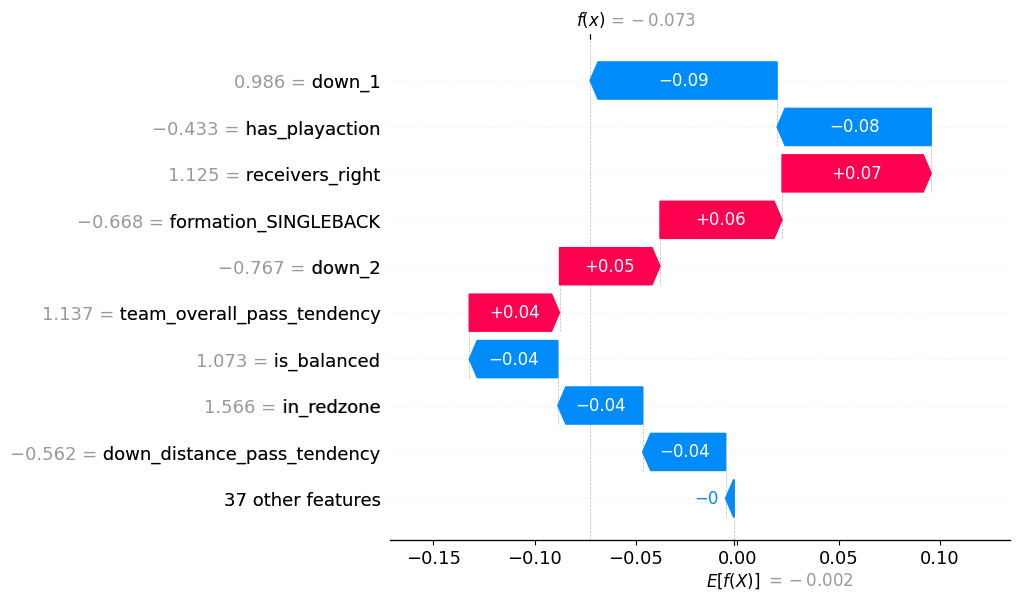

In [46]:
# Calculate base value and get first few predictions
base_value = shap_values[0].mean()
shap_values_few = shap_values[0][:1]  

e = shap.Explainer(model, shap_values.squeeze())

shap.waterfall_plot(
    shap.Explanation(
        values=shap_values.squeeze()[0],
        base_values=base_value,
        data=test_targets[0].cpu().numpy(),
        feature_names=X.columns.tolist()
    ),
    show=False
)
plt.show()
